In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import seaborn as sns

In [2]:
# 1. Monte Carlo Simulation for Option Pricing

def heston_mc_simulation(params, S0, r, T, n_simulations=10000, n_steps=252):
    kappa, theta, sigma, rho, v0 = params
    dt = T / n_steps
    S = np.zeros((n_steps, n_simulations))
    v = np.zeros((n_steps, n_simulations))
    S[0] = S0
    v[0] = v0  # This should now work as v0 is a float

    for t in range(1, n_steps):
        z1 = np.random.normal(size=n_simulations)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_simulations)
        v[t] = np.abs(v[t-1] + kappa * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1] * dt) * z1)
        S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * z2)

    return S[-1]

In [3]:
def heston_pricing_function(params, S0, r, T, K, option_type="call"):
    simulations = heston_mc_simulation(params, S0, r, T)
    if option_type == "call":
        payoffs = np.maximum(simulations - K, 0)
    elif option_type == "put":
        payoffs = np.maximum(K - simulations, 0)
    return np.exp(-r * T) * np.mean(payoffs)

In [4]:
# 2. Model Calibration

# Dummy market data (e.g., option prices)
dummy_market_data = np.random.uniform(10, 15, 10)

# Objective function for Heston model calibration
def heston_objective(params, market_data, S0, r, T, K, option_type="call"):
    model_prices = heston_pricing_function(params, S0, r, T, K, option_type)
    error = np.sum((market_data - model_prices) ** 2)
    return error


In [5]:
# Initial guess for parameters
initial_guess = [2.0, 0.1, 0.2, -0.7, 0.1]

In [6]:
# Calibrate the model
K = 100  # Strike price for calibration
result = minimize(heston_objective, initial_guess, args=(dummy_market_data, 100, 0.05, 1.0, K), method='L-BFGS-B')
calibrated_params = result.x

print("Calibrated Parameters:", calibrated_params)

C:\Users\TB Pal\AppData\Local\Temp\ipykernel_117484\356341463.py:13: RuntimeWarning: invalid value encountered in sqrt
  z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_simulations)
C:\Users\TB Pal\AppData\Local\Temp\ipykernel_117484\356341463.py:14: RuntimeWarning: invalid value encountered in sqrt
  v[t] = np.abs(v[t-1] + kappa * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1] * dt) * z1)
C:\Users\TB Pal\AppData\Local\Temp\ipykernel_117484\356341463.py:15: RuntimeWarning: invalid value encountered in sqrt
  S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * z2)


Calibrated Parameters: [ 2.00000178  0.10000407  0.2000008  -0.69999776  0.1000046 ]


In [7]:
# 3. Parameter Sensitivity Analysis

def sensitivity_analysis(params, S0, r, T, K, option_type="call"):
    sensitivities = {}
    for i, param_name in enumerate(['kappa', 'theta', 'sigma', 'rho', 'v0']):
        delta_params = np.copy(params)
        delta_params[i] *= 1.01  # Increase parameter by 1%
        price_high = heston_pricing_function(delta_params, S0, r, T, K, option_type)

        delta_params[i] /= 1.01 * 1.01  # Decrease parameter by 1%
        price_low = heston_pricing_function(delta_params, S0, r, T, K, option_type)

        sensitivities[param_name] = (price_high - price_low) / (2 * 0.01 * params[i])

    return sensitivities

In [8]:
sensitivities = sensitivity_analysis(calibrated_params, 100, 0.05, 1.0, K)
print("Parameter Sensitivities:", sensitivities)

Parameter Sensitivities: {'kappa': np.float64(5.154285504913304), 'theta': np.float64(94.27765318964472), 'sigma': np.float64(61.01285719760166), 'rho': np.float64(8.879795147103078), 'v0': np.float64(-102.23445221805544)}


In [9]:
# 4. Advanced Trading Strategy

def trading_strategy(S, v, sensitivities, threshold=0.02):
    signals = []
    for i in range(1, len(S)):
        if sensitivities['v0'] > threshold and v[i] > v[i-1]:  # Signal to sell
            signals.append(-1)
        elif sensitivities['v0'] < -threshold and v[i] < v[i-1]:  # Signal to buy
            signals.append(1)
        else:
            signals.append(0)  # Hold
    return signals

In [10]:
# Simulate dummy asset prices and volatilities
dummy_S = np.random.uniform(95, 105, 252)
dummy_v = np.random.uniform(0.08, 0.12, 252)

# Generate trading signals
signals = trading_strategy(dummy_S, dummy_v, sensitivities)
print("Trading Signals:", signals)

Trading Signals: [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


In [11]:
# 5. Backtesting with Performance Metrics

def backtest_strategy(signals, S, transaction_cost=0.001):
    cash = 100000  # Initial cash
    position = 0   # Number of shares
    portfolio_value = []
    daily_returns = []

    for i, signal in enumerate(signals):
        if signal == 1:  # Buy
            position += 1
            cash -= S[i] * (1 + transaction_cost)
        elif signal == -1:  # Sell
            position -= 1
            cash += S[i] * (1 - transaction_cost)
        portfolio_value.append(cash + position * S[i])
        if i > 0:
            daily_returns.append((portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2])

    return portfolio_value, daily_returns

In [12]:
portfolio_value, daily_returns = backtest_strategy(signals, dummy_S)

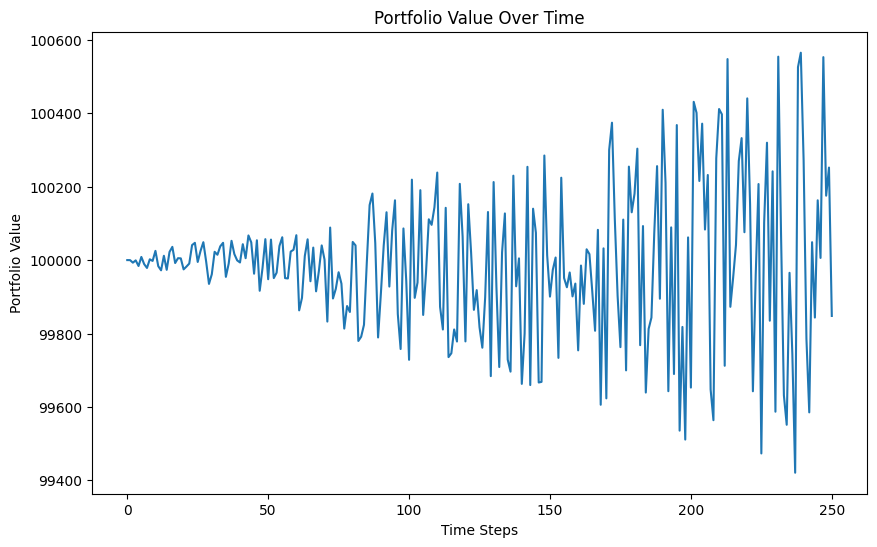

In [13]:
# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.show()

In [14]:
# Performance Metrics
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
win_loss_ratio = len([r for r in daily_returns if r > 0]) / len([r for r in daily_returns if r < 0])
print("Sharpe Ratio:", sharpe_ratio)
print("Win/Loss Ratio:", win_loss_ratio)

Sharpe Ratio: -0.009545964842536173
Win/Loss Ratio: 1.0491803278688525


In [15]:
# 6. Risk Management with Stop-Loss and Take-Profit

def max_drawdown(portfolio_value):
    peak = np.maximum.accumulate(portfolio_value)
    drawdown = (peak - portfolio_value) / peak
    max_dd = np.max(drawdown)
    return max_dd

In [16]:
def risk_management(portfolio_value, max_drawdown_threshold=0.2, stop_loss=0.1, take_profit=0.2):
    max_dd = max_drawdown(portfolio_value)
    if max_dd > max_drawdown_threshold:
        return "Stop Trading due to Drawdown"
    if (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0] > take_profit:
        return "Take Profit and Exit"
    if (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0] < -stop_loss:
        return "Stop Loss and Exit"
    return "Continue Trading"

In [17]:
# Assess the risk of the trading strategy
risk_status = risk_management(portfolio_value)
print("Risk Management Status:", risk_status)

Risk Management Status: Continue Trading


In [18]:
def option_price_heatmap(param_name, param_range, fixed_params, S0, r, T, K):
    prices = []
    for param_value in param_range:
        params = list(fixed_params.values())
        params[list(fixed_params.keys()).index(param_name)] = param_value
        price = heston_pricing_function(params, S0, r, T, K)
        prices.append(price)

    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array(prices).reshape(len(param_range), 1), annot=True, cmap="YlGnBu")
    plt.title(f'Option Prices vs. {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Option Price')
    plt.show()

In [19]:
# Define a range for each parameter
kappa_range = np.linspace(0.5, 3.0, 10)
theta_range = np.linspace(0.01, 0.2, 10)
sigma_range = np.linspace(0.1, 0.5, 10)

In [20]:
# Fixed parameters for the heatmap generation
fixed_params = {'kappa': 2.0, 'theta': 0.1, 'sigma': 0.2, 'rho': -0.7, 'v0': 0.1}

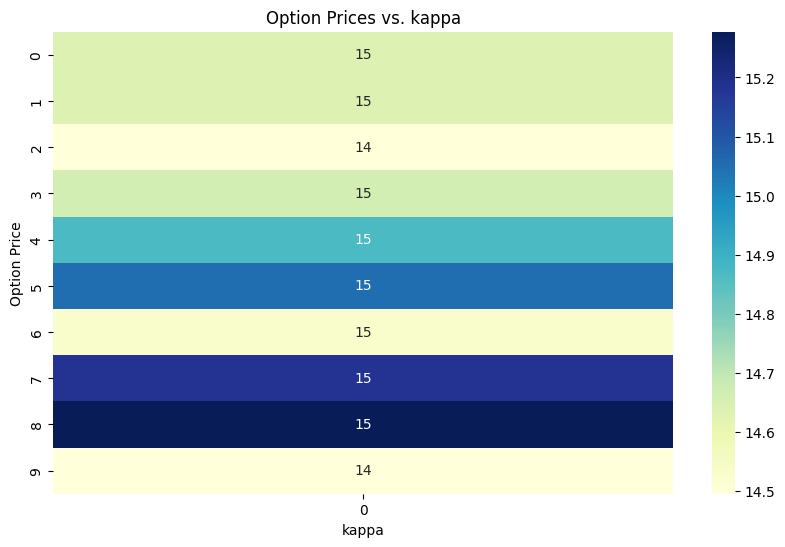

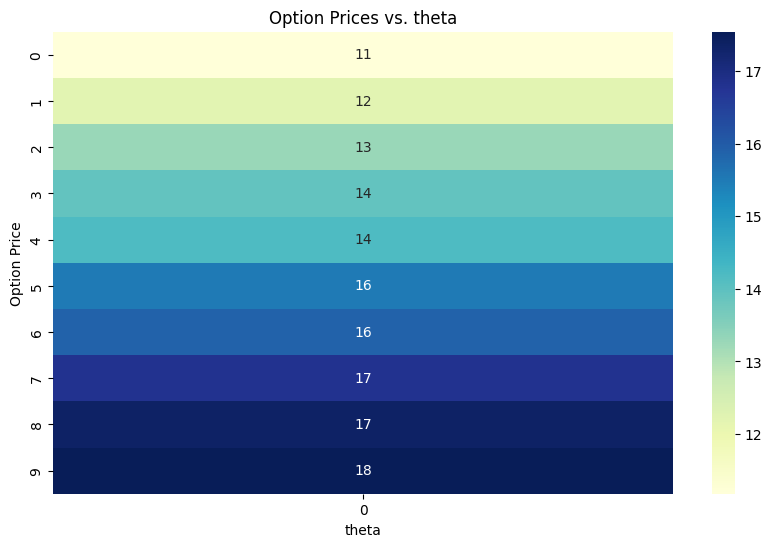

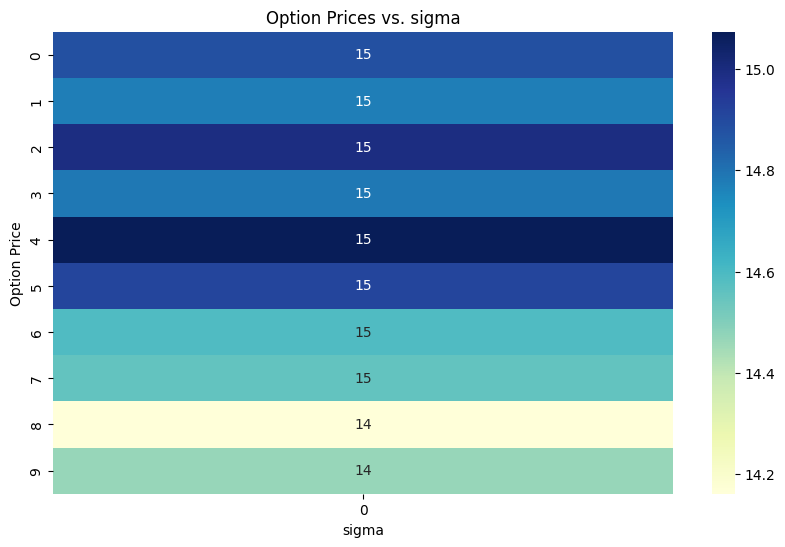

In [21]:
# Generate heatmaps for kappa, theta, and sigma
option_price_heatmap('kappa', kappa_range, fixed_params, 100, 0.05, 1.0, 100)
option_price_heatmap('theta', theta_range, fixed_params, 100, 0.05, 1.0, 100)
option_price_heatmap('sigma', sigma_range, fixed_params, 100, 0.05, 1.0, 100)

In [22]:
# Heatmap for Sharpe Ratio vs. Heston Model Parameters

def sharpe_ratio_heatmap(param_name, param_range, fixed_params, S0, r, T, K):
    sharpe_ratios = []
    for param_value in param_range:
        params = list(fixed_params.values())
        params[list(fixed_params.keys()).index(param_name)] = param_value
        _, daily_returns = backtest_strategy(signals, dummy_S)
        sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
        sharpe_ratios.append(sharpe_ratio)

    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array(sharpe_ratios).reshape(len(param_range), 1), annot=True, cmap="YlOrRd")
    plt.title(f'Sharpe Ratio vs. {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Sharpe Ratio')
    plt.show()

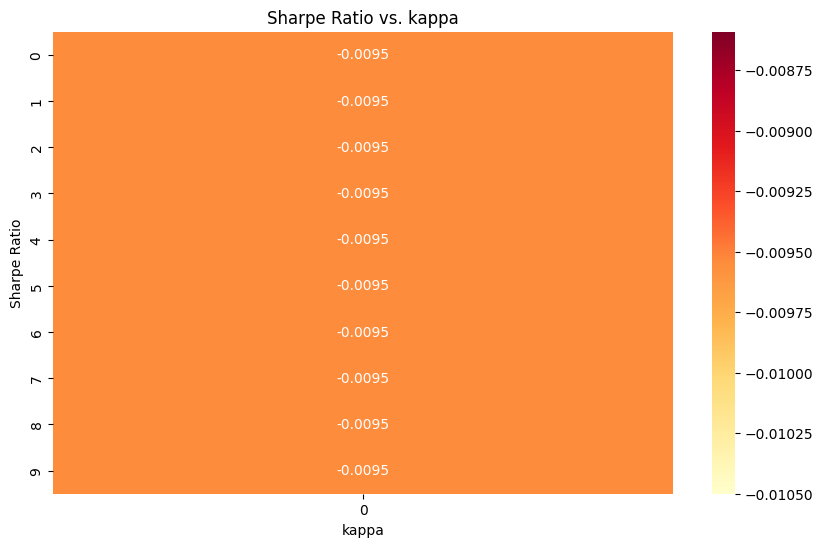

In [23]:
# Generate Sharpe ratio heatmaps
sharpe_ratio_heatmap('kappa', kappa_range, fixed_params, 100, 0.05, 1.0, 100)

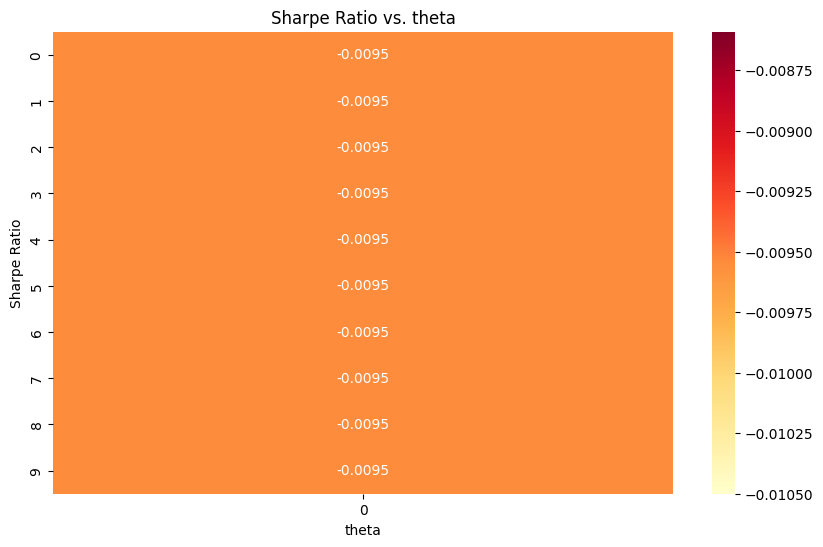

In [24]:
sharpe_ratio_heatmap('theta', theta_range, fixed_params, 100, 0.05, 1.0, 100)

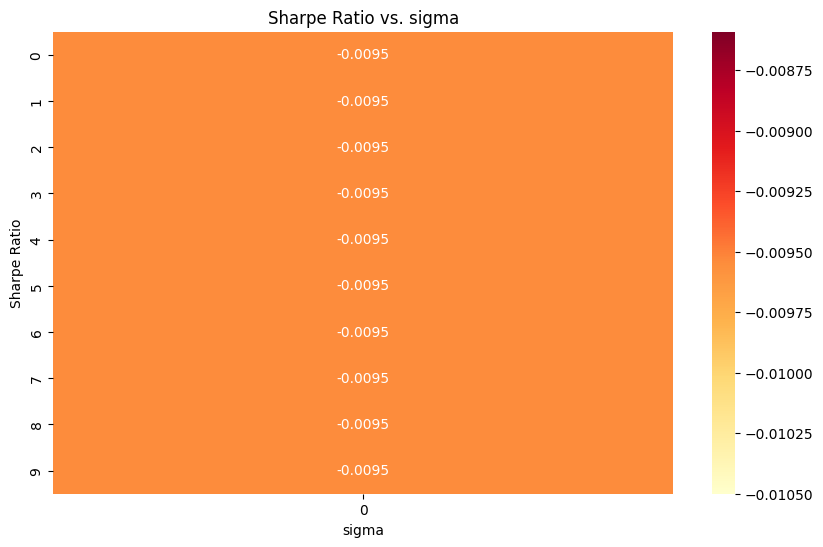

In [25]:
sharpe_ratio_heatmap('sigma', sigma_range, fixed_params, 100, 0.05, 1.0, 100)